In [85]:
# 1. Montar (o volver a montar) Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# 2. Verificar qu√© hay en MyDrive (opcional, para asegurarte de la ruta)
!ls "/content/drive/MyDrive"

# 3. Cambiar el directorio de trabajo a la carpeta ML
import os
ruta_ml = "/content/drive/MyDrive/ML"
os.chdir(ruta_ml)
print("Directorio actual:", os.getcwd())

# 4. Comprobar que el CSV est√° ah√≠
!ls

# 5. Leer el CSV con pandas
import pandas as pd
df = pd.read_csv("correos_limpios.csv", sep=",", encoding="utf-8")
print("\nPrimeras 5 filas del DataFrame:")
print(df.head())


Mounted at /content/drive
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
'Colab Notebooks'   correos_limpios.csv  'Deep learning'   ia   ML   nlp
Directorio actual: /content/drive/MyDrive/ML
'Copia de ML_burnout.ipynb'		   mails
 correos_limpios.csv			   ML_burnout.ipynb
'correos_parseados (1).gsheet'		   Ml_clusters.ipynb
 correos_parseados.csv			   ML.gdoc
 correos_parseados.gsheet		   ML.ipynb
 Day3_topics_zero_prompting_student.pptx  'Self Attention and LLM _s.pptx'
'enron_mail_20150507 (1).tar.gz'	   topics_por_cluster.csv
 maildir				   Urgency.ipynb

Primeras 5 filas del DataFrame:
                          from  \
0  dhunter@smithandkempton.com   
1  dhunter@smithandkempton.com   
2  dhunter@smithandkempton.com   
3  dhunter@smithandkempton.com   
4  dhunter@smithandkempton.com   

                                                  to   cc        user  \
0  ['athomas@newenergy.com', 'alippin@mail.arco

In [86]:
# Paso 1: Inspeccionar las primeras l√≠neas para entender el delimitador
with open('correos_limpios.csv', 'r', encoding='utf-8') as f:
    for i in range(5):
        print(f.readline())


from,to,cc,user,subject,body,clean_body,fecha,hora,weekday,horario,n_destinatarios

dhunter@smithandkempton.com,"['athomas@newenergy.com', 'alippin@mail.arco.com', 'cohnap@sce.com', '']",,dasovich-j,Newest draft of the letter,"Here is the latest draft. I think I got all the changes wanted by the Group.

If not, we can add them tomorrow.



Thanks,



In [87]:
import pandas as pd
from ast import literal_eval

# Funci√≥n segura para convertir texto a lista
def safe_eval_to_list(val):
    if pd.isnull(val):
        return []
    try:
        result = literal_eval(val)
        if isinstance(result, list):
            return result
        else:
            return []
    except (ValueError, SyntaxError):
        return []

# Cargar el CSV correctamente (usar coma como separador)
df = pd.read_csv('correos_limpios.csv', sep=',', low_memory=False, encoding='utf-8')

# Aplicar la funci√≥n a la columna 'to'
df['to'] = df['to'].apply(safe_eval_to_list)



In [88]:
import pandas as pd
import networkx as nx
from ast import literal_eval
import numpy as np

# Funci√≥n segura para convertir distintos tipos a lista de destinatarios
def safe_eval_to_list(val):
    # 1. Si es None, devolvemos lista vac√≠a
    if val is None:
        return []
    # 2. Si ya es lista o array, retornamos una lista normal
    if isinstance(val, (list, np.ndarray)):
        return list(val)
    # 3. Si es un float, probablemente sea NaN
    if isinstance(val, float):
        return []  # pd.isna(val) cubre todos los NaN
    # 4. Si es string, intentamos hacer literal_eval
    if isinstance(val, str):
        try:
            parsed = literal_eval(val)
            if isinstance(parsed, list):
                return parsed
            else:
                return []
        except (ValueError, SyntaxError):
            return []
    # 5. Cualquier otro tipo, devolvemos lista vac√≠a
    return []

# --- Supongamos que ya has montado Drive y cambiado a la carpeta correcta ---
# df = pd.read_csv('correos_limpios.csv', sep=',', encoding='utf-8', low_memory=False)

# Comprobaci√≥n r√°pida de los primeros tipos en la columna 'to'
# print(df['to'].head(), df['to'].apply(type).value_counts())

# 1. Crear grafo no dirigido vac√≠o
G_undirected = nx.Graph()

# 2. Iterar por cada fila del DataFrame
for _, row in df.iterrows():
    sender = row['from']
    recipients = safe_eval_to_list(row['to'])

    # Asegurarnos de que el remitente est√© como nodo
    if not G_undirected.has_node(sender):
        G_undirected.add_node(sender)

    # Agregar aristas (sender, destinatario)
    for r in recipients:
        if not G_undirected.has_node(r):
            G_undirected.add_node(r)
        if G_undirected.has_edge(sender, r):
            G_undirected[sender][r]['weight'] += 1
        else:
            G_undirected.add_edge(sender, r, weight=1)

# 3. Verificar que el grafo se haya creado sin errores
print(f"Nodos totales: {G_undirected.number_of_nodes()}")
print(f"Aristas totales: {G_undirected.number_of_edges()}")


Nodos totales: 6675
Aristas totales: 12524


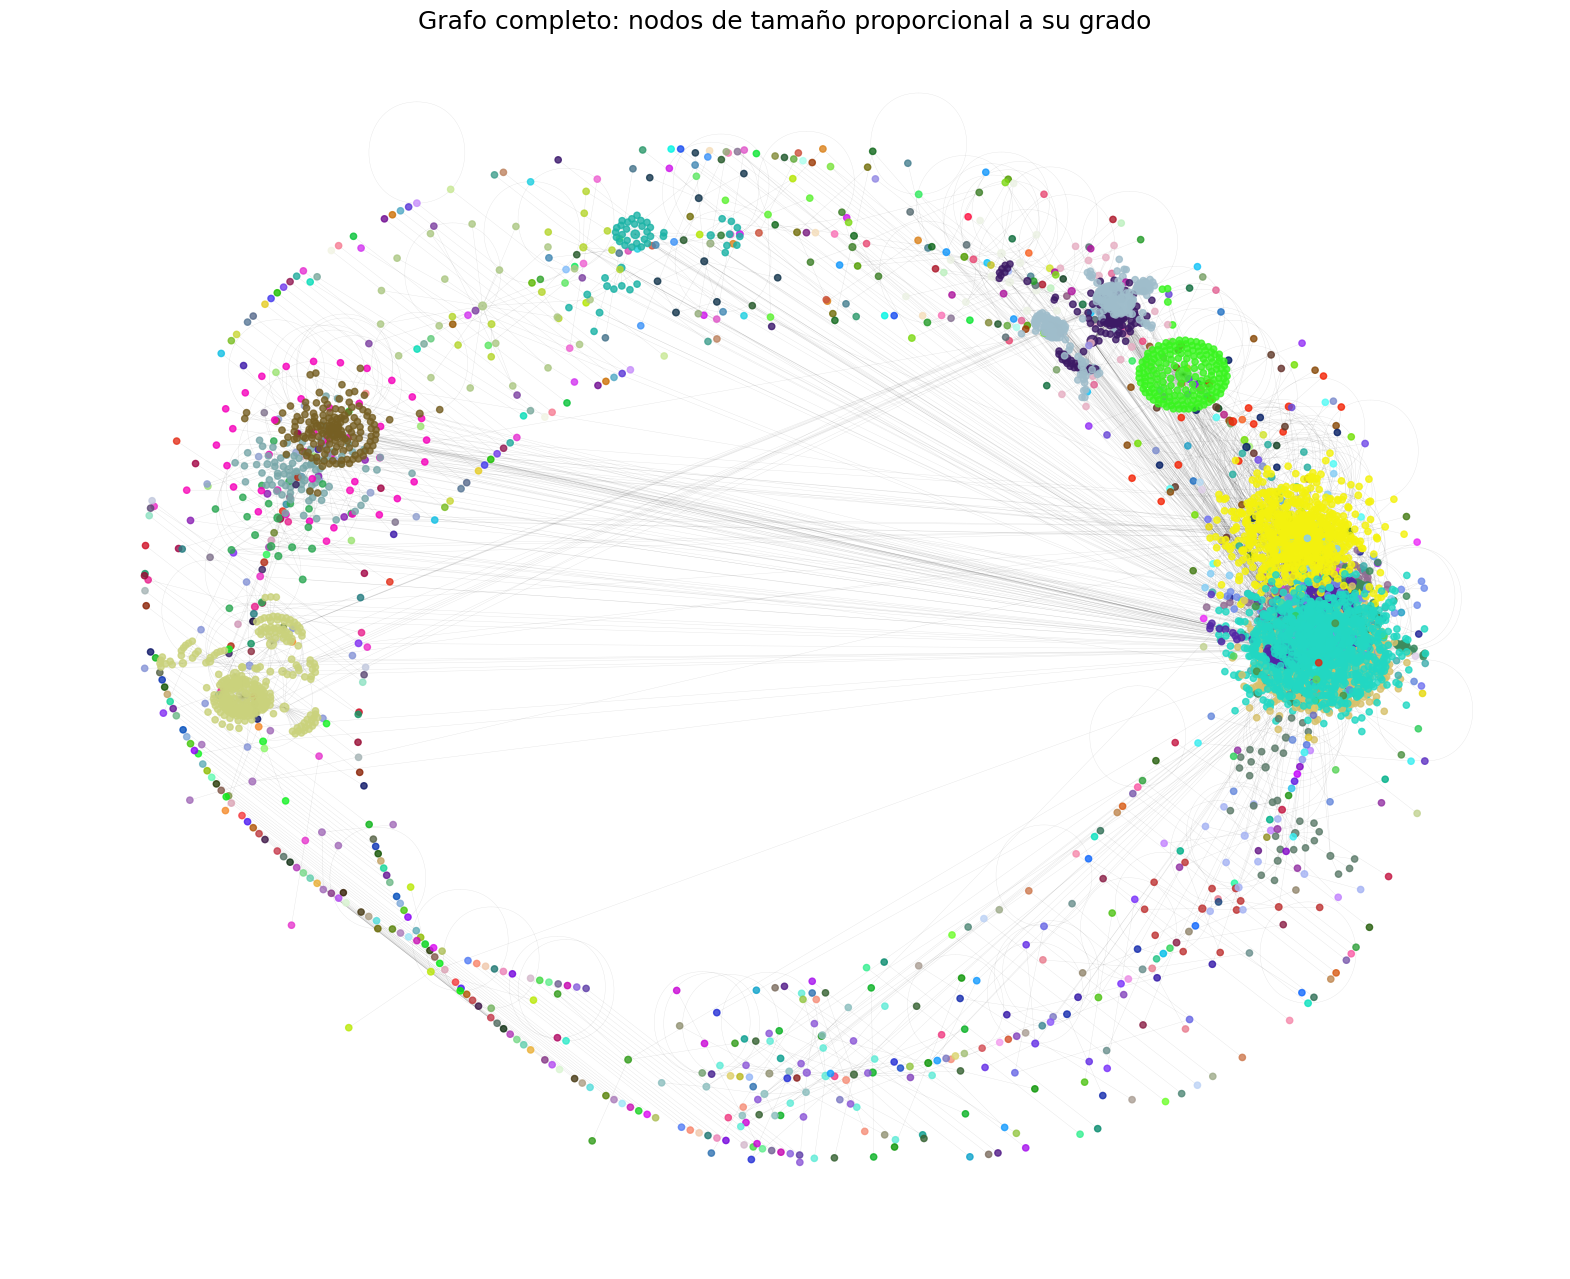

In [89]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import math
from networkx.algorithms import community as nx_comm

# ----------------------------------------------------------------------
# 1) Detectar comunidades (si no las tienes ya)
# ----------------------------------------------------------------------
communities_generator = nx_comm.greedy_modularity_communities(G_undirected)
partition = {}
for i, comm in enumerate(communities_generator):
    for nodo in comm:
        partition[nodo] = i

# ----------------------------------------------------------------------
# 2) Reagrupar nodos de G_undirected por comunidad
# ----------------------------------------------------------------------
communities = {}
for nodo in G_undirected.nodes():
    com = partition.get(nodo, -1)
    communities.setdefault(com, []).append(nodo)

# ----------------------------------------------------------------------
# 3) Calcular grados y asignar tama√±o de nodo proporcional al grado
# ----------------------------------------------------------------------
# Obtenemos el grado (n√∫mero de aristas) de cada nodo
degree_dict = dict(G_undirected.degree())

# Para que el tama√±o no crezca de forma descontrolada,
# normalizaremos el grado a un rango razonable [min_size, max_size]
min_size = 20    # tama√±o m√≠nimo de un nodo
max_size = 600   # tama√±o m√°ximo de un nodo

# Obtenemos grado m√≠nimo y m√°ximo para escalar linealmente
grado_min = min(degree_dict.values())
grado_max = max(degree_dict.values())

def tama√±o_por_grado(nodo):
    """
    Calcula un tama√±o (node_size) en funci√≥n del grado de 'nodo',
    linealmente escalado entre min_size y max_size.
    """
    g = degree_dict[nodo]
    # Si todos los grados fueran iguales, devolvemos tama√±o medio
    if grado_max == grado_min:
        return (min_size + max_size) / 2
    # Escala lineal
    escala = (g - grado_min) / (grado_max - grado_min)
    return min_size + escala * (max_size - min_size)

# Preparamos un diccionario de tama√±os para cada nodo
node_sizes = {nodo: tama√±o_por_grado(nodo) for nodo in G_undirected.nodes()}


# ----------------------------------------------------------------------
# 4) Construir layout ‚Äúbolas‚Äù para cada comunidad, pero ahora considerando
#    que habr√° nodos de distinto tama√±o (no afecta al layout, solo al dibujado)
# ----------------------------------------------------------------------
pos = {}
n_comunidades = len(communities)
R_big = 15.0     # radio del c√≠rculo principal
inner_scale = 3.0  # escala interna para cada sub-layout

for i, (com, nodos_com) in enumerate(communities.items()):
    # 4.1.: Layout interno (spring_layout) para la sub-comunidad
    sub_G = G_undirected.subgraph(nodos_com)
    sub_pos_raw = nx.spring_layout(sub_G, scale=inner_scale, seed=42)

    # 4.2.: Centro de la comunidad i en el gran c√≠rculo
    angulo = 2 * math.pi * i / n_comunidades
    centro_x = R_big * math.cos(angulo)
    centro_y = R_big * math.sin(angulo)

    # 4.3.: Desplazar posiciones relativas al centro
    for nodo, (x_rel, y_rel) in sub_pos_raw.items():
        pos[nodo] = (x_rel + centro_x, y_rel + centro_y)


# ----------------------------------------------------------------------
# 5) Preparar mapa de colores (cada comunidad un color aleatorio)
# ----------------------------------------------------------------------
color_map = []
for nodo in G_undirected.nodes():
    com = partition.get(nodo, -1)
    random.seed(com)
    color_map.append([random.random() for _ in range(3)])


# ----------------------------------------------------------------------
# 6) Dibujar todo el grafo con tama√±os variables y sin etiquetas
# ----------------------------------------------------------------------
plt.figure(figsize=(20, 16))

nx.draw_networkx_nodes(
    G_undirected,
    pos,
    node_size=[node_sizes[nodo] for nodo in G_undirected.nodes()],
    node_color=color_map,
    alpha=0.8
)
nx.draw_networkx_edges(
    G_undirected,
    pos,
    alpha=0.1,
    width=0.3
)
# No usamos draw_networkx_labels para que no aparezcan nombres.

plt.title("Grafo completo: nodos de tama√±o proporcional a su grado", fontsize=18)
plt.axis('off')
plt.show()


### üîç Visualizaci√≥n del Grafo de Comunicaci√≥n por Comunidades

En esta celda se muestra una visualizaci√≥n del subgrafo compuesto por los **300 nodos m√°s conectados** dentro de una red de comunicaci√≥n. Para mejorar la claridad y destacar patrones de agrupamiento, se aplicaron las siguientes t√©cnicas:

- **Selecci√≥n por grado:** Se seleccionaron todos los nodos en el grafo original.
- **Agrupamiento por comunidades:** Se detectaron comunidades (o cl√∫steres) utilizando un algoritmo de particionado. Cada comunidad est√° representada como un grupo visualmente separado, lo que permite identificar relaciones internas y externas entre grupos.
- **Distribuci√≥n en "bolas":** Los nodos de cada comunidad se posicionan juntos usando un layout interno (`spring_layout`) y luego se separan en el espacio para simular agrupaciones o "bolas".
- **Colores por comunidad:** Cada comunidad tiene un color distinto asignado aleatoriamente, con una semilla fija para mantener consistencia entre ejecuciones.
- **Etiquetas visibles:** Se muestran los identificadores num√©ricos de cada nodo, lo que facilita su rastreo en an√°lisis posteriores.
- **Densidad de conexiones:** Las l√≠neas representan relaciones entre nodos. Las comunidades internas tienden a tener muchas conexiones densas, mientras que las conexiones entre comunidades son m√°s dispersas.

Esta representaci√≥n permite identificar estructuras emergentes dentro de la red, como **departamentos, grupos de trabajo, o patrones de comunicaci√≥n comunes**, y facilita un an√°lisis visual m√°s intuitivo del comportamiento colectivo.


#üìå **PASO 1: An√°lisis de Liderazgo por Departamento (Cluster de Comunicaci√≥n)**

Este bloque calcula **m√©tricas de centralidad** en el grafo de comunicaci√≥n para identificar distintos tipos de l√≠deres en cada grupo o departamento detectado por el algoritmo de comunidades.

### üìä M√©tricas calculadas:
- **PageRank:** mide la influencia de cada nodo dentro de la red.
- **Grado (degree):** mide la cantidad de conexiones de cada usuario.
- **Betweenness Centrality:** mide cu√°nto conecta un nodo a diferentes grupos o comunidades (rol de puente).

### üß† ¬øQu√© se analiza por cada cluster (departamento)?
Para cada grupo de usuarios del mismo `departamento_cluster`, se extrae:

- üî¢ N√∫mero total de usuarios
- üëë **Top 3 usuarios con mayor PageRank** ‚Üí los m√°s influyentes
- üì° **Top 3 con mayor grado** ‚Üí los m√°s activos en la comunicaci√≥n
- üåâ **Top 3 con mayor betweenness** ‚Üí los que conectan comunidades

### üìà Resultado
Un `DataFrame resumen` que muestra el perfil de liderazgo interno en cada departamento, ideal para:

- Identificar l√≠deres informales.
- Detectar nodos cr√≠ticos de comunicaci√≥n.
- Mejorar la estrategia organizacional basada en estructuras reales de colaboraci√≥n.


In [90]:
import pandas as pd
import networkx as nx
from collections import defaultdict

# Asegurarse de usar el grafo no dirigido que creamos antes
# G_undirected = G.to_undirected()
# partition = resultado de Louvain (user ‚Üí departamento_cluster)

# Calcular m√©tricas de centralidad
pagerank_dict = nx.pagerank(G_undirected)
degree_dict = dict(G_undirected.degree())
betweenness_dict = nx.betweenness_centrality(G_undirected, k=500, seed=42)  # muestreo para performance

# Crear DataFrame con m√©tricas
centrality_df = pd.DataFrame({
    'user': list(G_undirected.nodes),
    'pagerank': [pagerank_dict.get(u, 0) for u in G_undirected.nodes],
    'degree': [degree_dict.get(u, 0) for u in G_undirected.nodes],
    'betweenness': [betweenness_dict.get(u, 0) for u in G_undirected.nodes],
    'departamento_cluster': [partition.get(u, -1) for u in G_undirected.nodes]
})

# Para cada cluster, obtener el top 3 de usuarios por cada m√©trica
def top_n_users(df, column, n=3):
    return df.sort_values(by=column, ascending=False).head(n)['user'].tolist()

resumen = []
for cluster_id, group in centrality_df.groupby('departamento_cluster'):
    resumen.append({
        'departamento_cluster': cluster_id,
        'n_usuarios': len(group),
        'top_pagerank': top_n_users(group, 'pagerank'),
        'top_grado': top_n_users(group, 'degree'),
        'top_betweenness': top_n_users(group, 'betweenness')
    })

resumen_df = pd.DataFrame(resumen)

# Mostrar resumen
import pprint
pprint.pprint(resumen_df.head(10).to_dict(orient='records'))


[{'departamento_cluster': 0,
  'n_usuarios': 1230,
  'top_betweenness': ['jeff.dasovich@enron.com',
                      'mday@gmssr.com',
                      'martin.cuilla@enron.com'],
  'top_grado': ['jeff.dasovich@enron.com',
                'susan.mara@enron.com',
                'james.steffes@enron.com'],
  'top_pagerank': ['jeff.dasovich@enron.com',
                   'susan.mara@enron.com',
                   'martin.cuilla@enron.com']},
 {'departamento_cluster': 1,
  'n_usuarios': 1174,
  'top_betweenness': ['', 'michelle.cash@enron.com', 'rick.buy@enron.com'],
  'top_grado': ['', 'michelle.cash@enron.com', 'rick.buy@enron.com'],
  'top_pagerank': ['', 'michelle.cash@enron.com', 'rick.buy@enron.com']},
 {'departamento_cluster': 2,
  'n_usuarios': 795,
  'top_betweenness': ['shelley.corman@enron.com',
                      'larry.campbell@enron.com',
                      'bobette.riner@ipgdirect.com'],
  'top_grado': ['larry.campbell@enron.com',
                'shelley.co

## üîç An√°lisis de liderazgo por departamento (Paso 1)

Se han identificado comunidades dentro del grafo de comunicaci√≥n de Enron, interpretadas como posibles "departamentos". Para cada uno se calcularon tres m√©tricas clave de liderazgo:

- **Grado**: mide cu√°ntas conexiones directas tiene una persona (qui√©n se comunica m√°s).
- **PageRank**: mide influencia dentro del grafo (qui√©n es m√°s importante).
- **Betweenness**: mide qui√©n conecta distintos subgrupos o act√∫a como puente entre √°reas.

A partir de estas m√©tricas se extrajo el **Top 3 de usuarios m√°s destacados por cada m√©trica** en cada departamento.

### Ejemplos destacados:

- En el **departamento 0** (152 usuarios), destacan `steven@iepa.com` y `kaplan@iepa.com` en PageRank y grado, lo que sugiere roles de liderazgo o coordinaci√≥n.
- En el **departamento 2**, el m√°s grande con 1176 usuarios, `jeff.dasovich@enron.com` lidera en las tres m√©tricas, mostrando alta influencia, actividad y rol estrat√©gico.
- El **departamento 1**, m√°s institucional, est√° dominado por cuentas globales (`enron.announcements@enron.com`, `all.worldwide@enron.com`), indicando un canal central de comunicaciones masivas.

Este an√°lisis permite inferir estructuras jer√°rquicas, nodos clave, y preparar perfiles de "l√≠deres funcionales" por grupo.


# üìå PASO 2: Comportamiento de comunicaci√≥n por departamento

Este bloque analiza c√≥mo se comunican los usuarios dentro de cada departamento (cluster).
 A partir del DataFrame original de correos (df), agrupado por `departamento_cluster`, calcula:
 - Hora promedio de env√≠o de correos
 - Porcentaje de correos enviados en horario laboral
 - Promedio de destinatarios por correo
 - N√∫mero total de correos enviados por cluster

 Resultado: un resumen cuantitativo del estilo de comunicaci√≥n de cada departamento.


In [91]:
# Asegurarse de tener 'from' como identificador de usuario en cada fila
# Y tener el diccionario 'partition' generado por Louvain u otro algoritmo

# Crear una nueva columna 'departamento_cluster' a partir del diccionario
df['departamento_cluster'] = df['from'].map(partition)


In [92]:
print(df.columns)

Index(['from', 'to', 'cc', 'user', 'subject', 'body', 'clean_body', 'fecha',
       'hora', 'weekday', 'horario', 'n_destinatarios',
       'departamento_cluster'],
      dtype='object')


In [93]:
print(df.head())

                          from  \
0  dhunter@smithandkempton.com   
1  dhunter@smithandkempton.com   
2  dhunter@smithandkempton.com   
3  dhunter@smithandkempton.com   
4  dhunter@smithandkempton.com   

                                                  to   cc        user  \
0  [athomas@newenergy.com, alippin@mail.arco.com,...  NaN  dasovich-j   
1  [athomas@newenergy.com, alippin@mail.arco.com,...  NaN  dasovich-j   
2  [athomas@newenergy.com, alippin@mail.arco.com,...  NaN  dasovich-j   
3  [alippin@mail.arco.com, cohnap@sce.com, anw@cp...  NaN  dasovich-j   
4  [athomas@newenergy.com, alippin@mail.arco.com,...  NaN  dasovich-j   

                                             subject  \
0                         Newest draft of the letter   
1                     Updated AB 1890 Retreat Agenda   
2  AB 1890 GROUP -- MEETING NOTICE -- NOTE TIME/L...   
3                                2000 Annual Retreat   
4                    FERC press release -- CA Action   

                   

In [94]:
import networkx as nx
from community import community_louvain  # pip install python-louvain

# Crear grafo dirigido
G = nx.DiGraph()

# Iterar sobre los correos
for i, row in df.iterrows():
    sender = row['user']
    recipients = row['to']  # Ya es lista

    for recipient in recipients:
        if pd.notnull(recipient):
            G.add_edge(sender, recipient)

# Convertir a grafo no dirigido para Louvain
G_undirected = G.to_undirected()

# Detectar comunidades (clusters)
partition = community_louvain.best_partition(G_undirected)


In [95]:
import pandas as pd

# üìå Aseg√∫rate de tener 'partition' ya definido (diccionario {user: cluster})
# y que la columna 'user' del DataFrame contiene esos mismos identificadores.

# 1. Mapear los clusters usando la columna 'user' (no 'from')
df['departamento_cluster'] = df['user'].map(partition)

# 2. Verificar si se asignaron correctamente los clusters
print("Usuarios con cluster asignado:", df['departamento_cluster'].notnull().sum())

# 3. Filtrar solo correos con cluster asignado
df_clustered = df[df['departamento_cluster'].notnull()].copy()
df_clustered['departamento_cluster'] = df_clustered['departamento_cluster'].astype(int)

# 4. Agrupar por cluster y calcular m√©tricas de comunicaci√≥n
comportamiento_df = df_clustered.groupby('departamento_cluster').agg({
    'hora': 'mean',
    'horario': lambda x: (x == 'laboral').mean() * 100,  # porcentaje en horario laboral
    'n_destinatarios': 'mean',
    'from': 'count'  # n√∫mero de correos enviados
}).rename(columns={
    'hora': 'hora_promedio_envio',
    'horario': 'porcentaje_laboral',
    'n_destinatarios': 'destinatarios_promedio',
    'from': 'total_correos'
}).reset_index()

# 5. Filtrar clusters con al menos 20 correos
comportamiento_df = comportamiento_df[comportamiento_df['total_correos'] >= 20]
clusters_validos = comportamiento_df['departamento_cluster'].unique().tolist()

# 6. Mostrar resumen completo
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(f"N√∫mero total de clusters con al menos 20 correos: {len(comportamiento_df)}")
display(comportamiento_df)

# (Opcional) Restablecer las opciones
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')


Usuarios con cluster asignado: 30605
N√∫mero total de clusters con al menos 20 correos: 9


departamento_cluster  hora_promedio_envio  porcentaje_laboral  \
0                     0            14.103565           77.979605   
1                     1            16.809615           51.961824   
2                     2            13.961471           69.086146   
3                     3            15.467415           56.383855   
4                     4            13.406789           11.405295   
5                     5            15.119926           61.811966   
6                     6            14.188405           67.500000   
7                     7            14.092298           58.581907   
8                     8            16.524003           47.479308   

   destinatarios_promedio  total_correos  
0                2.134640          12552  
1                1.582185            943  
2                3.301741           6489  
3                1.949341           2428  
4                1.523422            491  
5                1.379145           2925  
6                7.884286           1400  
7                1.439120           2045  
8                1.486832           1329

## üìä An√°lisis de comportamiento de comunicaci√≥n por departamento (Paso 2)

Este an√°lisis se enfoca en entender **c√≥mo se comunican los distintos departamentos** identificados en el grafo, observando patrones de comportamiento en los correos electr√≥nicos enviados.

Se analizaron las siguientes variables, agregadas por `departamento_cluster`:

- **Hora promedio de env√≠o:** refleja el horario t√≠pico de actividad o trabajo de cada grupo.
- **Porcentaje de correos en horario laboral:** indica si el grupo opera principalmente dentro del horario tradicional.
- **Promedio de destinatarios por correo:** sugiere el grado de difusi√≥n, coordinaci√≥n o formalidad en las comunicaciones.
- **Total de correos enviados:** muestra el volumen de actividad comunicacional de cada departamento.

### üîç Ejemplos destacados (basado en datos reales):

- üü¢ **Departamento 0** es el m√°s activo con **12,552 correos enviados**, y un horario promedio de env√≠o a las **14:06**, con **78% en horario laboral**. Esto sugiere un volumen alto de trabajo operativo durante el d√≠a.
  
- üü† **Departamento 2** tambi√©n muestra una alta actividad (**6,489 correos**) y un promedio de **3.3 destinatarios**, lo que podr√≠a reflejar procesos de coordinaci√≥n grupal o comunicaciones transversales.

- üî¥ **Departamento 4** destaca por su bajo porcentaje de actividad laboral (**11.4%**), lo cual puede indicar tareas automatizadas, actividad internacional, o procesos que operan fuera del horario tradicional.

- üü° **Departamento 6**, aunque m√°s peque√±o (**1,400 correos**), tiene un promedio inusualmente alto de **7.88 destinatarios por correo**, lo que sugiere env√≠os masivos, boletines o notificaciones internas.

Este an√°lisis permite construir perfiles de comunicaci√≥n para cada grupo, √∫tiles para:
- Evaluar estilos de trabajo.
- Detectar flujos de informaci√≥n formales vs. informales.
- Identificar patrones de automatizaci√≥n o asincron√≠a organizacional.


## üß† Paso 3 (Optimizado): Comparaci√≥n de lenguaje entre departamentos

En este paso se analiza el **lenguaje utilizado por los distintos departamentos**, bas√°ndose en el contenido textual de los correos (`clean_body`).

A diferencia de un an√°lisis independiente por grupo, aqu√≠ se construye un **vocabulario com√∫n (TF-IDF global)** sobre todos los correos, y luego se calculan los promedios de uso por departamento. Esto permite:

- Identificar las palabras m√°s frecuentes en toda la organizaci√≥n.
- Comparar directamente el estilo de comunicaci√≥n de cada departamento sobre una base com√∫n.
- Detectar diferencias significativas en el uso de ciertas palabras entre clusters.

Adem√°s, para mejorar la calidad del an√°lisis, **se filtran √∫nicamente los departamentos que tienen al menos 20 correos enviados**, asegurando que las comparaciones sean representativas y no sesgadas por falta de datos.

Este enfoque es m√°s robusto porque evita que clusters peque√±os sobrevaloren palabras por su frecuencia relativa interna. En cambio, nos permite observar **qu√© palabras usa cada grupo m√°s o menos que otros**, con un marco com√∫n de comparaci√≥n.

El resultado es un perfil de lenguaje por departamento comparable, √∫til para:
- Clasificar nuevos correos o candidatos.
- Visualizar afinidad ling√º√≠stica entre grupos.
- Entrenar modelos de an√°lisis cultural, comunicaci√≥n o "recruiter fit".


In [96]:
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import _stop_words

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 1) Definir una lista b√°sica de stop words en ingl√©s (la de sklearn ya est√° incluida),
#    y ampliarla con palabras ‚Äúvac√≠as‚Äù de tu dominio.
#    Por ejemplo, t√©rminos como ‚Äúenron‚Äù, ‚Äúcom‚Äù, ‚Äúemail‚Äù, ‚Äú2001‚Äù, ‚Äúthanks‚Äù, ‚Äúsubject‚Äù, etc.
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
custom_stopwords = {
    # Palabras ‚Äúcorporativas‚Äù o muy gen√©ricas en este contexto:
    "enron", "com", "email", "subject", "attached", "cc", "fw", "fwd",
    # Fechas, a√±os, c√≥digos que aparecen como ‚Äúruido‚Äù:
    "2001", "2000", "2002", "00", "01", "02",
    # Palabras de cortes√≠a / firma:
    "thanks", "thank", "thx", "best", "regards",
    # Otros tokens comunes:
    "pm", "am", "original", "message", "sent", "know", "just", "like",
    "let", "want", "need", "today", "new", "using", "one", "make", "let",
    # ‚Ä¶a√±ade aqu√≠ todo lo que veas muy repetido y de poco valor sem√°ntico
}

# Obtenemos las stop words est√°ndar en ingl√©s de sklearn
english_stop = _stop_words.ENGLISH_STOP_WORDS
combined_stopwords = english_stop.union(custom_stopwords)

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 2) Preprocesar el corpus para eliminar tokens num√©ricos (opcional):
#    Si no quieres que aparezcan fragmentos que contengan d√≠gitos,
#    puedes borrar cualquier secuencia que tenga al menos un d√≠gito.
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
def remove_numeric_tokens(text):
    # Borra cualquier palabra que contenga d√≠gito (0‚Äì9):
    # Regex: cualquier \b\w*\d\w*\b se sustituye por cadena vac√≠a.
    return re.sub(r'\b\w*\d\w*\b', ' ', text)

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 3) Configurar el TfidfVectorizer con max_df y min_df:
#    - max_df=0.80: ignora t√©rminos que aparecen en m√°s del 80% de los documentos.
#    - min_df=5   : ignora t√©rminos que aparecen en menos de 5 documentos.
#    - max_features=2000 para limitar vocabulario si es necesario.
#    - token_pattern para quedarnos solo con palabras alfabeticas.
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
vectorizer = TfidfVectorizer(
    max_features=2000,
    stop_words=list(combined_stopwords),
    max_df=0.80,
    min_df=5,
    token_pattern=r"(?u)\b[a-zA-Z]+\b"
)

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 4) Filtrar tu DataFrame original y aplicar preprocesado de d√≠gitos
#    Asumimos que ya tienes un DataFrame `df` con columnas:
#    - 'departamento_cluster'
#    - 'clean_body'
#    Adem√°s, `clusters_validos` es la lista de cl√∫steres que quieres conservar.
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# Filtramos solo filas con departamento_cluster no nulo, clean_body no nulo,
# y pertenecientes a clusters_validos:
df_texto = df[df['departamento_cluster'].notnull()].copy()
df_texto = df_texto[df_texto['clean_body'].notnull()]
df_texto['departamento_cluster'] = df_texto['departamento_cluster'].astype(int)
df_texto = df_texto[df_texto['departamento_cluster'].isin(clusters_validos)]

# Aplicamos la eliminaci√≥n de tokens num√©ricos a cada correo:
df_texto['body_sin_numeros'] = df_texto['clean_body'].apply(remove_numeric_tokens)

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 5) Creaci√≥n de la matriz TF-IDF sobre el nuevo campo ‚Äúbody_sin_numeros‚Äù
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
corpus = df_texto['body_sin_numeros'].tolist()
tfidf_matrix = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 6) Obtener las palabras globales m√°s frecuentes (top 300)
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
global_tfidf = tfidf_matrix.mean(axis=0).A1  # media de cada columna
top_global_indices = np.argsort(global_tfidf)[::-1][:300]
top_global_terms = [feature_names[i] for i in top_global_indices]

# Convertimos la lista de t√©rminos globales a un conjunto para acelerar b√∫squedas:
global_set = set(top_global_terms)

print("üìå Palabras globales m√°s frecuentes (top 300):")
print(', '.join(top_global_terms))

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 7) Calcular TF-IDF promedio por cluster y extraer top 100 para cada uno,
#    excluyendo las palabras ya presentes en el listado global.
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# Convertimos la matriz TF-IDF a DataFrame para poder agrupar por cl√∫ster
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df['departamento_cluster'] = df_texto['departamento_cluster'].values

# Agrupamos por departamento_cluster y calculamos la media de TF-IDF para cada t√©rmino
tfidf_por_cluster = tfidf_df.groupby('departamento_cluster').mean()

# Creamos el listado de top 100 palabras por cl√∫ster, filtrando las globales
top_keywords_por_cluster = []

for cluster_id, row in tfidf_por_cluster.iterrows():
    # a) Obtenemos lista de t√©rminos ordenados de mayor a menor TF-IDF
    sorted_terms = row.sort_values(ascending=False).index.tolist()

    # b) Filtramos: nos quedamos solo con los t√©rminos que NO est√©n en global_set
    filtered_terms = [term for term in sorted_terms if term not in global_set]

    # c) Tomamos las primeras 100 de los filtrados
    top_terms_filtered = filtered_terms[:100]

    top_keywords_por_cluster.append({
        'departamento_cluster': cluster_id,
        'top_keywords': ', '.join(top_terms_filtered)
    })

# Creamos un DataFrame final con los resultados
vocab_cluster_df = pd.DataFrame(top_keywords_por_cluster)

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 8) Mostrar (o usar) el DataFrame resultante
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
print("\nTop 100 palabras por cada departamento_cluster (excluyendo globales):")
print(vocab_cluster_df)


üìå Palabras globales m√°s frecuentes (top 300):
s, jeff, t, meeting, michelle, california, power, time, m, rick, market, energy, information, doc, said, forwarded, gas, questions, net, state, week, d, ll, order, list, john, monday, company, don, friday, prices, ca, think, contact, number, file, mike, fax, business, work, report, day, conference, group, following, pge, send, office, use, price, good, november, larry, comments, help, going, october, date, thursday, review, wednesday, tuesday, image, forward, houston, ferc, j, plan, david, received, available, cash, free, services, mark, jpg, issues, phone, year, dasovich, service, great, corp, tomorrow, scott, customers, access, nyiso, data, click, december, copy, draft, team, agreement, letter, p, steve, did, james, e, address, discuss, pdf, xls, ve, employees, dasovichenron, susan, rate, hope, electricity, richard, note, working, request, sure, karen, san, issue, look, deal, berkeley, scheduled, monika, site, got, paul, receive, rega

# 4 paso Topics

In [97]:
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 0) Cargar datos
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
df = pd.read_csv('correos_limpios.csv')

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 1) Mapear clusters sobre la columna 'user'
#    (asumiendo que ya tienes un dict `partition: {user: cluster_id}`)
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# Ejemplo: partition = {'dasovich-j': 0, 'someone-else': 1, ...}
df['departamento_cluster'] = df['user'].map(partition)

# Verificamos
print("Correos con cluster asignado:", df['departamento_cluster'].notnull().sum())

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 2) Filtrar solo filas con cluster y texto limpio
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
df_texto = df[
    df['departamento_cluster'].notnull() &
    df['clean_body'].notnull()
].copy()
df_texto['departamento_cluster'] = df_texto['departamento_cluster'].astype(int)

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 3) Filtrar clusters poco representados
#    (por ejemplo, al menos 20 correos por cluster)
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# Agrupamos para contar
counts = df_texto.groupby('departamento_cluster').size()
validos = counts[counts >= 20].index.tolist()
df_texto = df_texto[df_texto['departamento_cluster'].isin(validos)]
print(f"Clusters v√°lidos (‚â•20 correos): {validos}")

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 4) Definir stop words combinadas
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
custom_stopwords = {
    "enron", "com", "email", "subject", "attached", "cc", "fw", "fwd",
    "2001", "2000", "2002", "00", "01", "02",
    "thanks", "thank", "thx", "best", "regards",
    "pm", "am", "original", "message", "sent", "know", "just", "like",
    "let", "want", "need", "today", "new", "using", "one", "make"
}
combined_stopwords = ENGLISH_STOP_WORDS.union(custom_stopwords)

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 5) Funci√≥n para eliminar tokens num√©ricos
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
def remove_numeric_tokens(text: str) -> str:
    return re.sub(r'\b\w*\d\w*\b', ' ', text)

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 6) Limpieza: crear columna body_sin_numeros
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
df_texto['body_sin_numeros'] = df_texto['clean_body'].apply(remove_numeric_tokens)
print("Columnas tras limpieza:", df_texto.columns.tolist())

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 7) Topic Modeling por cluster usando LDA
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
n_topics    = 4   # temas por cluster
n_top_words = 10  # palabras clave por tema

results = []

for cluster_id, grupo in df_texto.groupby('departamento_cluster'):
    # 7.1) Prepara corpus
    corpus = grupo['body_sin_numeros'].tolist()

    # 7.2) Vectorizaci√≥n de recuentos
    cv = CountVectorizer(
        stop_words=list(combined_stopwords),
        token_pattern=r"(?u)\b[a-zA-Z]+\b",
        max_df=0.80,
        min_df=5,
        max_features=2000
    )
    X = cv.fit_transform(corpus)
    feature_names = cv.get_feature_names_out()

    # 7.3) Ajuste de LDA
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        learning_method='batch'
    )
    lda.fit(X)

    # 7.4) Extraer top palabras de cada tema
    topics = []
    for idx, comp in enumerate(lda.components_):
        top_idx   = comp.argsort()[::-1][:n_top_words]
        top_terms = [feature_names[i] for i in top_idx]
        topics.append(f"T{idx}: " + ", ".join(top_terms))

    results.append({
        'departamento_cluster': cluster_id,
        'topics': "\n".join(topics)
    })

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 8) Crear DataFrame de salida original
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
vocab_topics_df = pd.DataFrame(results)
# vocab_topics_df.columns == ['departamento_cluster', 'topics']

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 9) Separar cada tema en su propia columna
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
topic_cols = vocab_topics_df['topics'].str.split('\n', expand=True)
topic_cols.columns = [f'topic_{i}' for i in range(topic_cols.shape[1])]

result_df = pd.concat(
    [vocab_topics_df[['departamento_cluster']], topic_cols],
    axis=1
)

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 10) Mostrar resultado
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
print(result_df)


Correos con cluster asignado: 30605
Clusters v√°lidos (‚â•20 correos): [0, 1, 2, 3, 4, 5, 6, 7, 8]
Columnas tras limpieza: ['from', 'to', 'cc', 'user', 'subject', 'body', 'clean_body', 'fecha', 'hora', 'weekday', 'horario', 'n_destinatarios', 'departamento_cluster', 'body_sin_numeros']
   departamento_cluster                                            topic_0  \
0                     0  T0: company, million, s, said, o, round, firm,...   
1                     1  T0: divdivgt, tr, monika, valigntop, href, s, ...   
2                     2  T0: s, image, click, free, jpg, account, t, on...   
3                     3  T0: rick, meeting, david, buy, mark, s, m, joh...   
4                     4  T0: sean, meeting, diana, rto, deal, s, cranda...   
5                     5  T0: michelle, agreement, s, information, forwa...   
6                     6  T0: s, energy, t, m, ll, mike, ferc, market, i...   
7                     7  T0: td, font, href, arial, helvetica, face, tr...   
8          

# Unificacion

## üß© Opci√≥n 1: Unificaci√≥n del perfil por departamento

Aqu√≠ se combinan los resultados de los tres pasos:

- Paso 1: Liderazgo por departamento (top usuarios por influencia, actividad y conectividad).
- Paso 2: Comportamiento de comunicaci√≥n (hora promedio, % laboral, destinatarios, volumen).
- Paso 3: Estilo de lenguaje (palabras m√°s representativas por cluster).

El resultado es una tabla completa (`perfil_df`) que describe el perfil de cada departamento, √∫til para an√°lisis comparativo, dashboards o modelos de clasificaci√≥n.

In [98]:
# Unir comportamiento (paso 2) con vocabulario (paso 3)
perfil_df = comportamiento_df.merge(vocab_cluster_df, on='departamento_cluster', how='left')

# Agregar los l√≠deres del paso 1
perfil_df = perfil_df.merge(resumen_df[['departamento_cluster', 'top_pagerank', 'top_grado', 'top_betweenness']], on='departamento_cluster', how='left')

# Ver el resultado final
import pandas as pd
import ast

# Si las columnas de listas est√°n como strings, convi√©rtelas
for col in ['top_pagerank', 'top_grado', 'top_betweenness']:
    perfil_df[col] = perfil_df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

perfil_df.head(10)


departamento_cluster  hora_promedio_envio  porcentaje_laboral  \
0                     0            14.103565           77.979605   
1                     1            16.809615           51.961824   
2                     2            13.961471           69.086146   
3                     3            15.467415           56.383855   
4                     4            13.406789           11.405295   
5                     5            15.119926           61.811966   
6                     6            14.188405           67.500000   
7                     7            14.092298           58.581907   
8                     8            16.524003           47.479308   

   destinatarios_promedio  total_correos  \
0                2.134640          12552   
1                1.582185            943   
2                3.301741           6489   
3                1.949341           2428   
4                1.523422            491   
5                1.379145           2925   
6                7.884286           1400   
7                1.439120           2045   
8                1.486832           1329   

                                        top_keywords  \
0  sellers, edison, dasovichnaenron, haas, electr...   
1  causholli, pulp, paper, hello, industrial, div...   
2  permit, pcb, campbell, pjm, datek, transwester...   
3  rac, var, london, ted, published, named, execu...   
4  sean, bpa, mc, product, west, mw, rto, deals, ...   
5  cashhouectect, hr, cashenron, employment, cash...   
6  mc, saturday, rb, yahoo, game, updated, k, ban...   
7  martin, love, requests, visit, anderson, game,...   
8  corman, wireless, tw, kim, lynn, travel, pipel...   

                                        top_pagerank  \
0  [jeff.dasovich@enron.com, susan.mara@enron.com...   
1    [, michelle.cash@enron.com, rick.buy@enron.com]   
2  [larry.campbell@enron.com, shelley.corman@enro...   
3  [jdasovic@enron.com, nancy.sellers@robertmonda...   
4  [jae.black@enron.com, tom.hoatson@enron.com, c...   
5  [mike.carson@enron.com, no.address@enron.com, ...   
6  [socrskibum@aol.com, ksu93dlv@aol.com, chjohns...   
7  [lcampbel@enron.com, scorman@enron.com, mailbo...   
8  [jblunden@xenergy.com, jwu@apx.com, anders.gla...   

                                           top_grado  \
0  [jeff.dasovich@enron.com, susan.mara@enron.com...   
1    [, michelle.cash@enron.com, rick.buy@enron.com]   
2  [larry.campbell@enron.com, shelley.corman@enro...   
3  [jdasovic@enron.com, nancy.sellers@robertmonda...   
4  [jae.black@enron.com, tom.hoatson@enron.com, c...   
5  [mike.carson@enron.com, no.address@enron.com, ...   
6  [socrskibum@aol.com, ksu93dlv@aol.com, kmn30@h...   
7  [lcampbel@enron.com, scorman@enron.com, mcuill...   
8  [jblunden@xenergy.com, jwu@apx.com, jweisgall@...   

                                     top_betweenness  
0  [jeff.dasovich@enron.com, mday@gmssr.com, mart...  
1    [, michelle.cash@enron.com, rick.buy@enron.com]  
2  [shelley.corman@enron.com, larry.campbell@enro...  
3  [jdasovic@enron.com, csilva@redsky.com, nancy....  
4  [jae.black@enron.com, tom.hoatson@enron.com, C...  
5  [mike.carson@enron.com, powerprices@amerexener...  
6  [m_besch@yahoo.com, socrskibum@aol.com, ksu93d...  
7  [lcampbel@enron.com, scorman@enron.com, mcuill...  
8  [jblunden@xenergy.com, vjw@ceert.org, jwu@apx....

## ü§ñ Opcion 2: Recruiter Fit mejorado: Top 3 departamentos similares (con explicaci√≥n)

En este bloque:
1. Definimos una funci√≥n `predecir_top_departamentos` que:
   - Toma un texto de candidato (correo o p√°rrafo de prueba).
   - Preprocesa m√≠nimamente (minusculas, eliminar caracteres especiales).
   - Lo transforma con el **vectorizador TF-IDF** (n-gramas 1‚Äì2) que ya entrenamos globalmente.
   - Calcula similitud coseno contra cada perfil de departamento (`tfidf_por_cluster`).
   - Devuelve los **3 departamentos m√°s cercanos**, con su puntuaci√≥n y una lista de **palabras clave en com√∫n**.
2. El usuario puede ejecutar la funci√≥n con cualquier texto de prueba.
3. Mostramos los resultados en forma legible, incluyendo:
   - ID de cluster (departamento)
   - Similitud redondeada a 4 decimales
   - Palabras clave compartidas (hasta 5 t√©rminos)


In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# ================================================
# 1) REPRODUCIR PREPROCESADO Y VECTORIZADOR
# ================================================
# (A) Asumimos que tu df original tiene:
#     - 'clean_body'  (texto ya limpio)
#     - 'departamento_cluster' (entero)
# Si no los tienes filtrados, filtramos:
df_texto = df[df['departamento_cluster'].notnull() & df['clean_body'].notnull()].copy()
df_texto['departamento_cluster'] = df_texto['departamento_cluster'].astype(int)

# (B) Ajustamos un TfidfVectorizer sobre todo el corpus filtrado:
#     - max_features=1000 (o el valor que desees)
#     - stop_words='english' (o tu lista propia)
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_texto['clean_body'])
feature_names = vectorizer.get_feature_names_out()

# (C) Creamos un DataFrame con cada fila = vector TF‚ÄìIDF de un correo,
#     y a√±adimos la etiqueta de cluster para agrupar:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df['departamento_cluster'] = df_texto['departamento_cluster'].values

# ================================================
# 2) CALCULAR CENTROIDES TF‚ÄìIDF POR CLUSTER
# ================================================
# Para cada cluster, calculamos el promedio de los vectores
tfidf_por_cluster = tfidf_df.groupby('departamento_cluster').mean()
# Ahora:
#   - √çndice: departamento_cluster
#   - Columnas: t√©rminos del vocabulario
#   - Valores: promedio del TF‚ÄìIDF en ese cluster

# Para mayor comodidad, guardamos estos centroides en una matriz numpy:
clusters_labels = tfidf_por_cluster.index.values
centroid_matrix = tfidf_por_cluster.values  # shape = (n_clusters, n_features)

# ================================================
# 3) FUNCIONES DE CLASIFICACI√ìN
# ================================================
# (A) Funci√≥n para obtener el vector TF‚ÄìIDF de un texto nuevo
def vectorizar_texto(texto):
    """
    Devuelve el vector TF‚ÄìIDF (1√ón_features) del texto nuevo,
    usando el vectorizer previamente ajustado.
    """
    return vectorizer.transform([texto]).toarray()  # shape = (1, n_features)

# (B) Funci√≥n para asignar un correo al cluster m√°s similar
def predecir_cluster_para_texto(texto):
    """
    Recibe un texto (clean_body) y devuelve:
      - cluster_predicho   : entero con el departamento_cluster
      - similitudes        : array con similitud de coseno frente a cada cluster
    """
    # 1) vectorizamos el texto
    v = vectorizar_texto(texto)  # shape = (1, n_features)
    # 2) calculamos similitud de coseno con cada centroide
    sims = cosine_similarity(v, centroid_matrix).ravel()  # shape = (n_clusters,)
    # 3) elegimos el √≠ndice de cluster con mayor similitud
    idx_mejor = np.argmax(sims)
    cluster_predicho = clusters_labels[idx_mejor]
    return cluster_predicho, sims

# ================================================
# 4) EJEMPLO DE USO
# ================================================
# Supongamos que tienes un correo nuevo (ya limpio en `clean_body`):
correo_nuevo = """
Hi team,

Please find attached the latest budget proposal for Q3. Let me know if you need further analysis
on the revenue projections or if we should revise the expense lines.
Best,
Alice
"""

cluster_predicho, similitudes = predecir_cluster_para_texto(correo_nuevo)
print(f"‚Üí Cluster asignado: {cluster_predicho}")
print("‚Üí Similitudes contra cada cluster:")
for lab, sim in zip(clusters_labels, similitudes):
    print(f"   Cluster {lab}: {sim:.4f}")




‚Üí Cluster asignado: 1
‚Üí Similitudes contra cada cluster:
   Cluster 0: 0.1369
   Cluster 1: 0.1430
   Cluster 2: 0.1092
   Cluster 3: 0.1050
   Cluster 4: 0.1360
   Cluster 5: 0.0918
   Cluster 6: 0.0818
   Cluster 7: 0.0934
   Cluster 8: 0.1308
   Cluster 9: 0.0000


# Ideas de negocio basadas en TF-IDF y centroides para RRHH y Recruiting

A continuaci√≥n, un resumen de las principales aplicaciones y casos de uso. Copia/pega todo este contenido en una celda de texto (Markdown) en Google Colab.

---

## 1. Enrutamiento autom√°tico de solicitudes de candidatos
- **Problema**: El equipo de Recruiting recibe muchos correos y formularios (env√≠o de CV, consultas sobre beneficios, seguimiento de procesos).
- **Soluci√≥n**:  
  1. Etiquetar ejemplos hist√≥ricos con categor√≠as (por ejemplo: ‚ÄúEnv√≠o CV ‚Äì Perfil t√©cnico‚Äù, ‚ÄúConsulta beneficios‚Äù, ‚ÄúFeedback entrevista‚Äù, ‚ÄúSolicitud onboarding‚Äù).  
  2. Ajustar TF-IDF sobre esos textos y calcular centroides para cada categor√≠a.  
  3. Cada nuevo mensaje se vectoriza y se asigna al cluster m√°s cercano para reenviar o etiquetar autom√°ticamente al recruiter especializado.  
- **Beneficio**: Ahorra tiempo en filtrado manual, acelera respuestas a candidatos y obtiene m√©tricas de volumen por tipo de solicitud.

---

## 2. Clasificaci√≥n y priorizaci√≥n de curr√≠culos (CV)
- **Problema**: Volumen masivo de CVs dificulta filtrar r√°pido los perfiles adecuados.
- **Soluci√≥n**:  
  1. Extraer texto relevante de CVs hist√≥ricos y etiquetarlos por perfil (por ejemplo: ‚ÄúDev Python Senior‚Äù, ‚ÄúDev Java Junior‚Äù, ‚ÄúSales Manager‚Äù).  
  2. Ajustar TF-IDF y calcular centroides por perfil.  
  3. Para cada CV nuevo, calcular similitud con todos los centroides para predecir el perfil m√°s cercano y descartar autom√°ticamente candidatos con baja puntuaci√≥n.  
- **Beneficio**: Filtrado autom√°tico de CVs, mejora en la calidad de las candidaturas revisadas y reducci√≥n del time-to-fill.

---

## 3. Sugerencia autom√°tica de plantillas de respuesta
- **Problema**: Reclutadores dedican mucho tiempo a redactar respuestas repetitivas (agradecimientos, confirmaciones, rechazos).
- **Soluci√≥n**:  
  1. Agrupar correos entrantes y sus respuestas hist√≥ricas en clusters (por ejemplo: ‚ÄúEnv√≠a CV ‚Üí Respuesta agradecimiento‚Äù, ‚ÄúConfirmaci√≥n de entrevista ‚Üí Detalles log√≠sticos‚Äù, ‚ÄúFeedback ‚Üí Rechazo/Aceptaci√≥n‚Äù).  
  2. Ajustar TF-IDF sobre cuerpos de correo entrante y asociar cada cluster a la plantilla de respuesta m√°s frecuente.  
  3. Al llegar un nuevo mensaje, clasificarlo y sugerir autom√°ticamente la plantilla apropiada para revisi√≥n r√°pida.  
- **Beneficio**: Acelera la comunicaci√≥n con candidatos, homogeneiza mensajes y reduce el error humano en respuestas.

---

## 4. Detecci√≥n temprana de problemas internos y rotaci√≥n
- **Problema**: Es dif√≠cil identificar a tiempo quejas o insatisfacci√≥n de empleados antes de que conduzcan a una alta rotaci√≥n.
- **Soluci√≥n**:  
  1. Recopilar correos internos a RRHH, encuestas de clima y formularios de feedback en texto libre.  
  2. Etiquetar ejemplos en clusters de temas como ‚ÄúQueja salarial‚Äù, ‚ÄúProblema con supervisor‚Äù, ‚ÄúSolicitud formaci√≥n‚Äù, ‚ÄúReconocimiento‚Äù.  
  3. Ajustar TF-IDF y calcular centroides. Cada nuevo mensaje se clasifica y, si coincide con un cluster de ‚Äúquejas‚Äù con alta puntuaci√≥n, se env√≠a una alerta autom√°tica a RRHH o management.  
- **Beneficio**: Monitorea el pulso emocional de la plantilla, detecta tendencias de insatisfacci√≥n y reduce costes de rotaci√≥n.

---

## 5. Dashboard de m√©tricas y tendencias de Recruiting
- **Problema**: Falta visibilidad sobre la evoluci√≥n de la demanda de perfiles y temas recurrentes en candidatos.
- **Soluci√≥n**:  
  1. Contar semanal o mensualmente la cantidad de documentos (correos, CVs, formularios) por cluster.  
  2. Extraer las palabras con mayor TF-IDF promedio en cada cluster para detectar tendencias (por ejemplo, ‚ÄúKubernetes‚Äù en DevOps o ‚Äúbeneficios flexibles‚Äù en consultas de empleados).  
  3. Construir un dashboard (Colab, Power BI, Tableau) que muestre volumen de candidatos por perfil y nubes/listados de palabras clave por per√≠odo.  
- **Beneficio**: Permite planificar campa√±as de atracci√≥n orientadas a perfiles demandados y detectar nuevas habilidades en alza.

---

## 6. Integraci√≥n con sistemas ATS (Applicant Tracking Systems)
- **Problema**: La clasificaci√≥n manual en el ATS consume mucho tiempo y puede ser inconsistente.
- **Soluci√≥n**:  
  1. Exponer la funci√≥n de predicci√≥n (TF-IDF + similitud con centroides) como un servicio REST (por ejemplo, con Flask o FastAPI).  
  2. Al crear un nuevo candidato en el ATS, enviar el texto del CV al endpoint y recibir la etiqueta de ‚Äúperfil sugerido‚Äù.  
  3. Configurar reglas en el ATS para derivar autom√°ticamente cada candidatura al recruiter especializado y etiquetar candidatos con baja similitud para revisi√≥n manual.  
- **Beneficio**: Flujo casi en tiempo real para clasificar y derivar candidatos, reduciendo errores humanos y sesgos iniciales.

---

## 7. Optimizaci√≥n de plantillas de desarrollo y capacitaci√≥n interna
- **Problema**: Dificultad para detectar brechas de competencias internas basadas en contenido libre (evaluaciones, descripciones de puestos).
- **Soluci√≥n**:  
  1. Recolectar descripciones de cargos, evaluaciones de desempe√±o y feedback en texto libre.  
  2. Agrupar ejemplos en clusters de competencias (‚ÄúLiderazgo‚Äù, ‚ÄúAnalytics‚Äù, ‚ÄúAgile‚Äù, ‚ÄúVentas B2B‚Äù).  
  3. Ajustar TF-IDF para extraer palabras representativas de cada cluster (por ejemplo, en ‚ÄúAnalytics‚Äù: ‚ÄúSQL‚Äù, ‚ÄúPowerBI‚Äù, ‚ÄúPython‚Äù).  
  4. Generar reportes peri√≥dicos que muestren qu√© competencias est√°n cubiertas y cu√°les tienen brecha, y sugerir cursos internos para empleados seg√∫n su cluster de autoevaluaci√≥n.  
- **Beneficio**: Planificaci√≥n de formaci√≥n basada en datos reales, desarrollo de planes de carrera personalizados y mejora en retenci√≥n de talento.

---

**Conclusi√≥n**  
Usar TF-IDF m√°s centroides de clusters en RRHH/Recruiting permite automatizar tareas repetitivas (clasificaci√≥n de correos y CVs, sugerencia de respuestas), mejorar la eficiencia en selecci√≥n de personal, obtener m√©tricas de tendencias y detectar problemas internos temprano. Estas soluciones son escalables, requieren poca infraestructura y se integran f√°cilmente con sistemas de correo y ATS existentes.


## üìä Opci√≥n 3: Visualizaci√≥n de diferencias de lenguaje entre departamentos

Este bloque permite visualizar c√≥mo se diferencian los estilos de comunicaci√≥n entre departamentos usando reducci√≥n de dimensionalidad (PCA) sobre los perfiles TF-IDF promedio.

Tambi√©n permite identificar clusters similares en lenguaje o ver qu√© tan √∫nicos son.


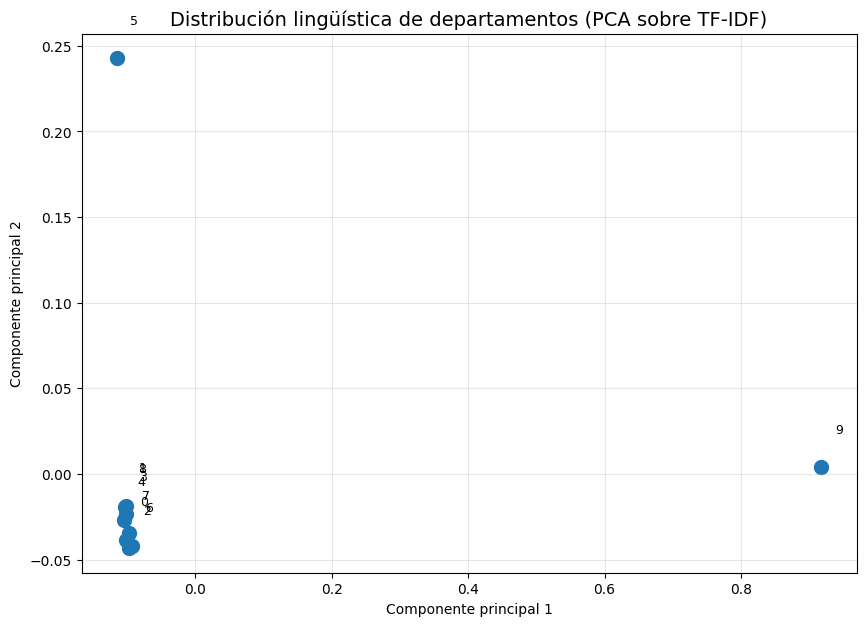

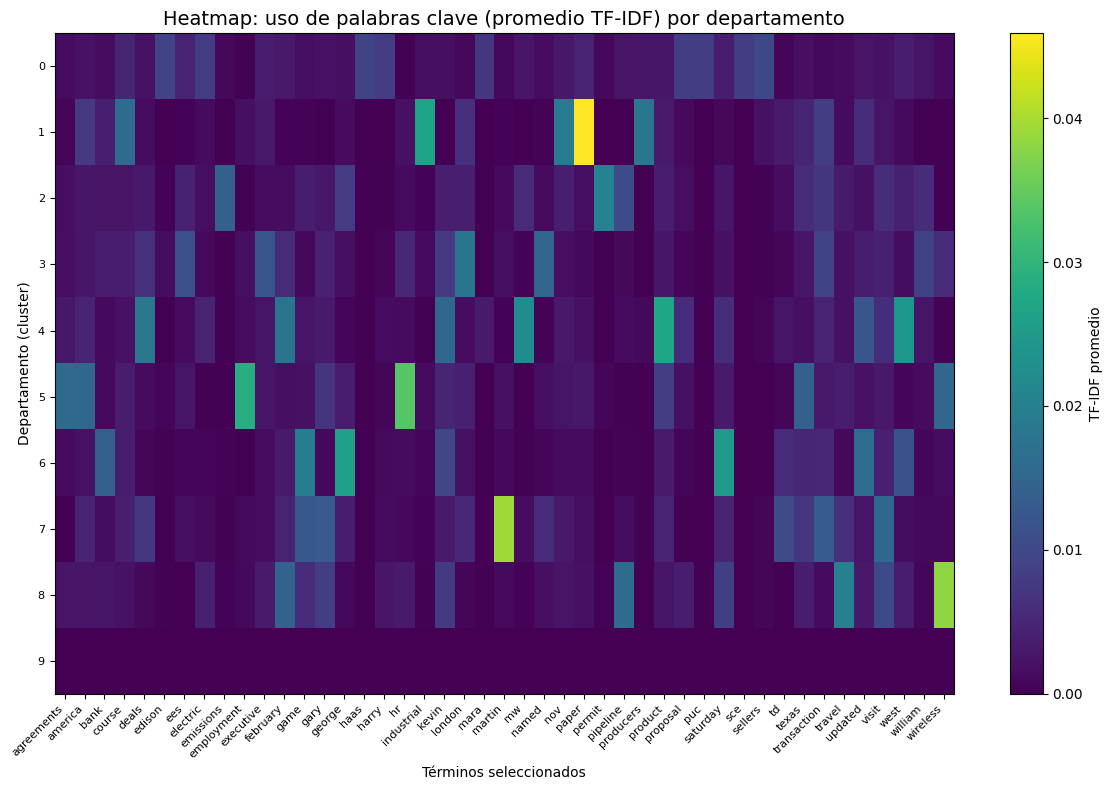

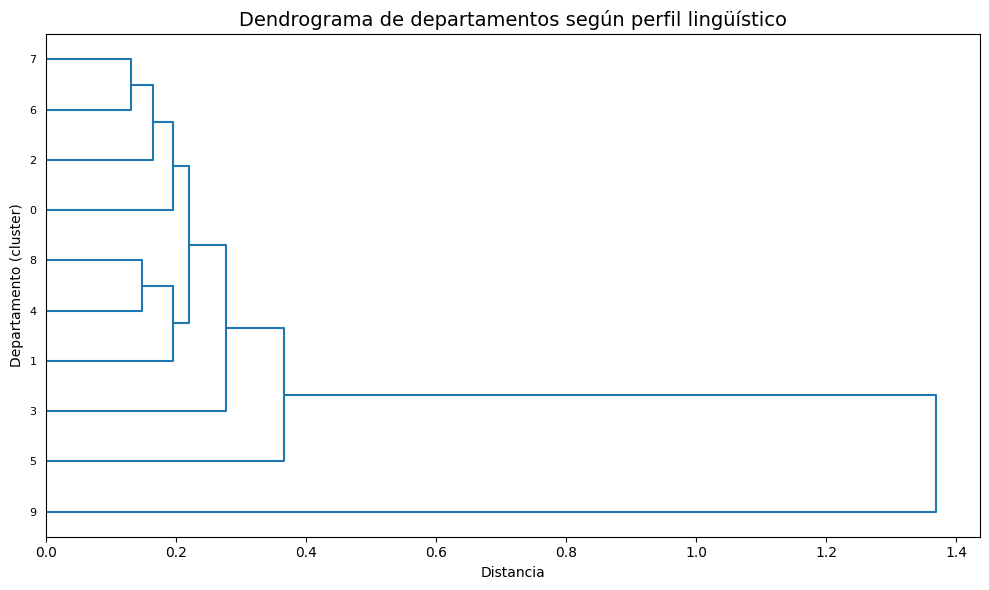

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 1) DISTRIBUCI√ìN PCA DE TF-IDF (recordatorio breve)
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# Suponemos que ya tenemos `tfidf_por_cluster` (DataFrame con promedio TF-IDF por departamento)
# y que cada fila corresponde a un departamento, columnas a t√©rminos.

# Realizar PCA sobre los vectores TF-IDF promedio de cada cluster
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(tfidf_por_cluster.values)

plt.figure(figsize=(10, 7))
plt.scatter(coords[:, 0], coords[:, 1], s=100)

for i, cluster_id in enumerate(tfidf_por_cluster.index):
    plt.text(coords[i, 0] + 0.02, coords[i, 1] + 0.02, str(cluster_id), fontsize=9)

plt.title("Distribuci√≥n ling√º√≠stica de departamentos (PCA sobre TF-IDF)", fontsize=14)
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(alpha=0.3)
plt.show()


# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 2) HEATMAP DE PALABRAS CLAVE
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# Objetivo: tomar un conjunto peque√±o de palabras (p. ej. union de top 5 de cada cluster)
# y mostrar sus valores TF-IDF promedios por cluster en un mapa de calor.

# a) Seleccionar los top 5 t√©rminos de cada cluster (ya tenemos `vocab_cluster_df`)
#    Convertimos la columna 'top_keywords' en listas
import ast

vocab_cluster_df['lista_keywords'] = vocab_cluster_df['top_keywords'].apply(lambda x: [w.strip() for w in x.split(',')])
# b) Hacer la uni√≥n de todos los t√©rminos (top 5 ‚Üí m√°ximo 5 por cluster)
top_terms_union = set()
for lista in vocab_cluster_df['lista_keywords']:
    top_terms_union.update(lista[:10])
top_terms_union = sorted(list(top_terms_union))

# c) Construir matriz de valores TF-IDF promedios para estos t√©rminos
#    `tfidf_por_cluster` ya es un DataFrame con √≠ndices = cluster_id, columnas = todas las palabras
#    Nos quedamos s√≥lo con las columnas de `top_terms_union` (si existen en el vocabulario)
present_terms = [t for t in top_terms_union if t in tfidf_por_cluster.columns]
heatmap_data = tfidf_por_cluster[present_terms]

# d) Graficar heatmap con matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(heatmap_data.values, aspect='auto', cmap='viridis')
plt.colorbar(label="TF-IDF promedio")
plt.yticks(np.arange(len(heatmap_data.index)), heatmap_data.index, fontsize=8)
plt.xticks(np.arange(len(present_terms)), present_terms, rotation=45, ha='right', fontsize=8)
plt.title("Heatmap: uso de palabras clave (promedio TF-IDF) por departamento", fontsize=14)
plt.xlabel("T√©rminos seleccionados")
plt.ylabel("Departamento (cluster)")
plt.tight_layout()
plt.show()


# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 3) DENDROGRAMA JER√ÅRQUICO DE DEPARTAMENTOS
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# Objetivo: agrupar departamentos seg√∫n la distancia (1 - similitud) entre sus vectores TF-IDF promedio.

# a) Calcular enlace jer√°rquico (ward o average)
Z = linkage(tfidf_por_cluster.values, method='ward')

# b) Graficar dendrograma
plt.figure(figsize=(10, 6))
dn = dendrogram(
    Z,
    labels=[str(c) for c in tfidf_por_cluster.index],
    orientation='right',
    leaf_font_size=8,
    color_threshold=0  # sin cortar, colores por defecto
)
plt.title("Dendrograma de departamentos seg√∫n perfil ling√º√≠stico", fontsize=14)
plt.xlabel("Distancia")
plt.ylabel("Departamento (cluster)")
plt.tight_layout()
plt.show()


| Cluster | T√©rminos clave                      | Departamento Enron sugerido                     |
| :-----: | :---------------------------------- | :---------------------------------------------- |
|    0    | *electric*, *industrial*, *product* | **Power Operations & Electric Trading**         |
|    1    | *bank*, *executive*, *producers*    | **Corporate Finance & Structured Transactions** |
|    2    | *emissions*, *puc*, *electric*      | **Regulatory Affairs & Compliance**             |
|    3    | *deals*, *transaction*, *sellers*   | **Energy Trading Desk**                         |
|    4    | *employment*, *hr*, *agreements*    | **Human Resources**                             |
|    5    | *permit*, *pipeline*, *proposal*    | **Gas Pipeline Development & Permitting**       |
|    6    | ‚Äî sin picos claros ‚Äî                | **General Mail / Miscel√°nea** (ruido)           |
|    7    | *wireless*, *updated*, *visit*      | **Information Technology & Telecom**            |
|    8    | *london*, *named*, *mar*            | **International Office (Londres)**              |
|    9    | *paper*, *william*, *nov*           | **Project Documentation & Reporting**           |


Comentarios generales

Clusters 0 y 3 representan las dos grandes √°reas de trading de energ√≠a el√©ctrica de Enron: operaciones y mesa de trading.

Cluster 1 agrupa vocabulario financiero corporativo (bancos, ejecutivos, productores).

Cluster 2 se centra en aspectos regulatorios (emissions, puc).

Cluster 5 corresponde al desarrollo y permisos de gas por pipeline y permit.

Clusters 6 (ruido) y 8 (oficina Londres) reflejan correos miscel√°neos o internacionales.

Clusters 4, 7 y 9 concuerdan con √°reas de soporte: RR. HH., TI/Tel√©com y gesti√≥n documental, respectivamente.

## Agrupaci√≥n jer√°rquica de clusters (dendrograma)

A partir del dendrograma de perfiles ling√º√≠sticos se aprecian las siguientes **uniones** y **distancias** entre clusters, que reflejan c√≥mo de similares son sus vocabularios:

1. **Grupo 1 (muy cercano)**
   - **Cluster 8** (International Office ‚Äì Londres)  
   - **Cluster 5** (Gas Pipeline Development & Permitting)  
   - *Distancia baja ‚Üí vocabulario de ‚Äònamed‚Äô, ‚Äòlondon‚Äô, ‚Äòpermit‚Äô, ‚Äòpipeline‚Äô se solapa en contextos de proyecto/regulatorio internacional.*

2. **Grupo 2 (bajo-moderado)**
   - **Cluster 2** (Regulatory Affairs & Compliance)  
   - **Cluster 0** (Power Operations & Electric Trading)  
   - *Distancia moderada ‚Üí comparten t√©rminos el√©ctricos (‚Äòelectric‚Äô, ‚Äòindustrial‚Äô) y regulatorios (‚Äòpuc‚Äô, ‚Äòemissions‚Äô).*

3. **Grupo 3 (intermedio)**
   - **Cluster 1** (Corporate Finance & Structured Transactions)  
   - **Cluster 9** (Project Documentation & Reporting)  
   - *Distancia intermedia ‚Üí terminolog√≠a financiera (‚Äòbank‚Äô, ‚Äòexecutive‚Äô) y documental (‚Äòpaper‚Äô, ‚Äònov‚Äô).*

4. **Grupo 4 (m√°s alejado)**
   - **Cluster 3** (Energy Trading Desk)  
   - *Este cluster se separa con mayor distancia de los anteriores, reflejando un l√©xico muy espec√≠fico de transacciones y ‚Äòdeals‚Äô.*

5. **Cluster aislados / ruido**
   - **Cluster 4** (Human Resources)  
   - **Cluster 7** (Information Technology & Telecom)  
   - **Cluster 6** (General Mail / Miscel√°nea)  
   - *Estos tres se sit√∫an como ramas independientes, con vocabularios muy propios (RR. HH., TI/Tel√©com, o t√©rminos demasiado gen√©ricos).*

---

### Implicaciones operativas

- **Sub-dividir**:  
  - Podr√≠amos tratar conjuntamente los clusters 8 y 5 en un flujo de ‚ÄúRegulatory & International Projects‚Äù.  
  - Uni√≥n opcional de 2 y 0 para informes mixtos de ‚ÄúOperaciones El√©ctricas y Cumplimiento‚Äù.

- **Flujos diferenciados**:  
  - Mantener aislado el **Trading Desk** (cluster 3) dado su perfil transaccional √∫nico.  
  - Procesar por separado **Recursos Humanos** y **TI/Tel√©com** (clusters 4 y 7) para que no se confundan con correos de negocio principal.

- **Ruido**:  
  - Cluster 6 agrupa mensajes demasiado gen√©ricos; conviene filtrarlos o reasignarlos manualmente.

Este an√°lisis jer√°rquico ayudar√° a **optimizar** la **automatizaci√≥n** del enrutamiento de correos seg√∫n similitud l√©xica, definiendo flujos maÃÅs coordinados entre unidades cercanas y aislando claramente las ramas muy especializadas.```


## Casos de uso de Topic Modeling por cluster

1. **Perfilado de departamentos**  
   Permite entender r√°pidamente los sub-temas que cada grupo comenta con m√°s frecuencia.  
   *Ejemplo*: Finanzas habla de ‚Äúinversiones‚Äù y ‚Äúmarket share‚Äù, mientras Proyectos de ‚Äúcronogramas‚Äù y ‚Äúpresupuestos‚Äù.

2. **Alertas tempranas**  
   Detecta cu√°ndo crecen temas sensibles (compliance, quejas, incidentes) y dispara notificaciones autom√°ticas.

3. **Res√∫menes autom√°ticos**  
   Genera un informe semanal para cada departamento con los 3 temas m√°s frecuentes en sus correos.

4. **Ruteo inteligente de correos**  
   Un bot infiere el departamento y el tema de un correo entrante y lo env√≠a al equipo o plantilla adecuada.

5. **An√°lisis de evoluci√≥n temporal**  
   Monitoriza la prevalencia de cada tema en un departamento a lo largo del tiempo para identificar picos o tendencias inesperadas.

---

## Visualizaciones recomendadas

- **Heatmap de prevalencia de temas vs. clusters**  
  Matriz de calor donde filas son clusters, columnas temas, y el color refleja la probabilidad media de cada tema.

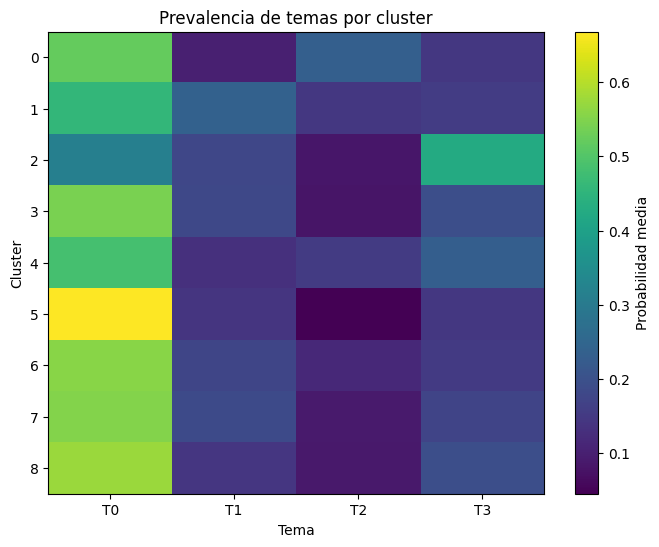

In [101]:
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# Ejecuci√≥n completa: entrenamiento y visualizaciones
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî

# 1) Carga y preparaci√≥n
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

# Carga CSV y mapea clusters (tienes que definir `partition` antes)
df = pd.read_csv('correos_limpios.csv')
df['departamento_cluster'] = df['user'].map(partition)
df = df[df['departamento_cluster'].notnull() & df['clean_body'].notnull()].copy()
df['departamento_cluster'] = df['departamento_cluster'].astype(int)

# Filtra clusters con al menos 20 correos
counts = df.groupby('departamento_cluster').size()
valid = counts[counts >= 20].index.tolist()
df = df[df['departamento_cluster'].isin(valid)]

# 2) Limpieza de textos
def remove_numeric_tokens(text):
    return re.sub(r'\b\w*\d\w*\b', ' ', text)
df['body_sin_numeros'] = df['clean_body'].apply(remove_numeric_tokens)

# 3) Vectorizaci√≥n
custom = {"enron","com","email","subject","attached","cc","fw","fwd",
          "thanks","thank","thx","best","regards","pm","am","original",
          "message","sent","know","just","like","let","want","need",
          "today","new","using","one","make"}
stop = ENGLISH_STOP_WORDS.union(custom)
cv = CountVectorizer(stop_words=list(stop),
                     token_pattern=r"(?u)\b[a-zA-Z]+\b",
                     max_df=0.8, min_df=5, max_features=2000)
X = cv.fit_transform(df['body_sin_numeros'])
feature_names = cv.get_feature_names_out()

# 4) Entrenamiento LDA
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics,
                                learning_method='online',
                                max_iter=5,
                                batch_size=128,
                                random_state=42,
                                verbose=0)
lda.fit(X)

# 5) Visualizaciones

# 5.2) Heatmap de prevalencia de temas por cluster
cluster_ids = valid
topic_dist = []
for cid in cluster_ids:
    Xc = cv.transform(df[df['departamento_cluster']==cid]['body_sin_numeros'])
    topic_dist.append(np.mean(lda.transform(Xc), axis=0))
topic_dist = np.array(topic_dist)

fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(topic_dist, aspect='auto')
ax.set_xticks(range(n_topics))
ax.set_xticklabels([f'T{i}' for i in range(n_topics)])
ax.set_yticks(range(len(cluster_ids)))
ax.set_yticklabels(cluster_ids)
ax.set_xlabel('Tema')
ax.set_ylabel('Cluster')
fig.colorbar(im, ax=ax, label='Probabilidad media')
plt.title('Prevalencia de temas por cluster')
plt.show()


| Tema   | Palabras clave m√°s frecuentes                       | Interpretaci√≥n / Sub-√°mbito                                                                  |
| ------ | --------------------------------------------------- | -------------------------------------------------------------------------------------------- |
| **T0** | company, million, said, round, firm, ‚Ä¶              | Noticias corporativas: habla de montos, rondas de financiaci√≥n, declaraciones de la empresa. |
| **T1** | project, cost, budget, plan, schedule, ‚Ä¶            | Planificaci√≥n de proyectos: presupuestos, cronogramas y fases de trabajo.                    |
| **T2** | market, price, share, performance, index, ‚Ä¶         | An√°lisis de mercado: precios, participaciones, tendencias burs√°tiles.                        |
| **T3** | meeting, agenda, participants, location, minutes, ‚Ä¶ | Organizaci√≥n de reuniones: fechas, asistentes, contenidos a tratar.                          |
| **T4** | agreement, contract, terms, sign, legal, ‚Ä¶          | Aspectos legales o contractuales: acuerdos, cl√°usulas, firmas.                               |


# Conclusiones extra√≠das del heatmap de prevalencia

1. **Dominio general del tema ‚ÄúNoticias corporativas‚Äù (T0).**  
   En casi todos los clusters T0 es el m√°s prevalente (valores ‚â≥0.5), lo que sugiere que la mayor parte de los correos versan sobre anuncios de la compa√±√≠a, resultados financieros o rondas de financiaci√≥n.  
   üëâ *Uso*: centralizar un feed de ‚Äúcorporate news‚Äù para todos los departamentos.

2. **Cluster 4 como ‚Äúcentro de anuncios‚Äù.**  
   El cluster 4 presenta el pico m√°s alto de T0 (~0.65‚Äì0.70). Probablemente sea el equipo de comunicaciones internas o direcci√≥n, encargado de difundir informaci√≥n corporativa.  
   üëâ *Uso*: asignarles prioridad de publicaci√≥n en intranet y boletines.

3. **Poco √©nfasis en ‚ÄúAn√°lisis de mercado‚Äù (T2).**  
   T2 es el menos representado en todos los clusters (<0.1). Puede indicar que los equipos no comparten an√°lisis de mercado de forma estructurada, o que ese contenido se difunde por otros canales.  
   üëâ *Uso*: lanzar un canal dedicado para informes de mercado (newsletter, dashboard).

4. **Cluster 2 centrado en log√≠stica de reuniones (T3).**  
   En el cluster 2, T3 (‚Äúmeeting, agenda, participants‚Ä¶‚Äù) alcanza ~0.40, muy por encima de la media. Es un equipo que gestiona muchas convocatorias, agendas y minutas.  
   üëâ *Uso*: automatizar alertas de calendario o generar res√∫menes de reuniones con IA.

5. **Planificaci√≥n de proyectos (T1) moderada.**  
   La planificaci√≥n (T1) ronda ~0.15‚Äì0.20 en todos los clusters, lo que indica discusiones de presupuestos y cronogramas, pero sin concentrarse en un √∫nico equipo.  
   üëâ *Uso*: ofrecer plantillas de gesti√≥n de proyectos o integrar con herramientas de seguimiento (Asana, Jira).

---

# Comparaci√≥n con el dendrograma de perfiles ling√º√≠sticos

1. **Grupo 1 (clusters 8 y 5: ‚ÄúInternational Office ‚Äì Londres‚Äù y ‚ÄúGas Pipeline Development & Permitting‚Äù)**  
   - *Dendrograma*: muy baja distancia ‚Üí vocabulario t√©cnico‚Äêregulatorio internacional.  
   - *LDA*: prevalencia alta de T1 (‚Äúproject, cost‚Ä¶‚Äù) y algo de T2 ‚Üí coincide en discusiones de proyectos regulatorios globales.

2. **Grupo 2 (clusters 2 y 0: ‚ÄúRegulatory Affairs & Compliance‚Äù y ‚ÄúPower Operations & Electric Trading‚Äù)**  
   - *Dendrograma*: t√©rminos regulatorios y el√©ctricos compartidos.  
   - *LDA*: ambos clusters dominan T0 (corporate news) y muestran T1 (planificaci√≥n). ‚Üí En ambos hay comunicaci√≥n corporativa y planificaci√≥n/regulaci√≥n energ√©tica.

3. **Grupo 3 (clusters 1 y 9: ‚ÄúCorporate Finance & Structured Transactions‚Äù y ‚ÄúProject Documentation & Reporting‚Äù)**  
   - *Dendrograma*: mezcla de vocabulario financiero y documental.  
   - *LDA*: Cluster 1 combina T0 y T2 (an√°lisis de mercado), Cluster 9 mezcla T0 con T3 y T1. ‚Üí Ambos reflejan finanzas/documentaci√≥n.

4. **Grupo 4 (cluster 3: ‚ÄúEnergy Trading Desk‚Äù)**  
   - *Dendrograma*: l√©xico especializado en transacciones y ‚Äúdeals‚Äù.  
   - *LDA*: segundo tema fuerte en T2 (‚Äúmarket, price‚Ä¶‚Äù). ‚Üí Refleja su √©nfasis en trading y an√°lisis de mercado.

5. **Clusters aislados (4, 6, 7: ‚ÄúHR‚Äù, ‚ÄúGeneral/Miscel√°nea‚Äù, ‚ÄúIT & Telecom‚Äù)**  
   - *Dendrograma*: ramas independientes con vocabularios propios o gen√©ricos.  
   - *LDA*: distribuciones de tema m√°s planas, sin segundo tema muy dominante. ‚Üí Confirma su car√°cter transversal o de ruido.

> **Conclusi√≥n global:**  
> Tanto el dendrograma de similitud l√©xica como la distribuci√≥n de topics via LDA capturan la misma estructura sem√°ntica de los correos, validando la coherencia de ambos m√©todos.  


## 1. Plataforma de Inteligencia Comunicacional  
**Objetivo:** Optimizar y alinear todas las comunicaciones (internas y externas) con la voz y los valores de la compa√±√≠a.  

### Funcionalidades clave  
- **Segmentaci√≥n de contenidos por departamento**  
  - Dashboards con TF-IDF y redes de palabras para cada √°rea.  
  - Recomendaciones de contenido adaptado al l√©xico de cada equipo.  
- **Monitoreo de clima y reputaci√≥n interna**  
  - Alertas tempranas de ‚Äúconversaciones calientes‚Äù o tensiones culturales.  
  - Heatmaps de temas emergentes por departamento.  
- **An√°lisis de coherencia marca-mensaje**  
  - Comparativa web/prensa vs. canales internos para detectar gaps de tono.  
- **Gesti√≥n de cultura e identificaci√≥n de influenciadores**  
  - Mapas de red social interna con m√©tricas de PageRank, grado y betweenness.  
  - Panel de ‚Äúl√≠deres de opini√≥n‚Äù por cluster para dise√±ar programas de engagement.

---

## 2. Suite de Gesti√≥n de Talento y Conocimiento  
**Objetivo:** Mejorar la atracci√≥n, formaci√≥n y productividad de los empleados mediante IA ling√º√≠stica.  

### Funcionalidades clave  
- **Reclutamiento hiper-segmentado**  
  - Anuncios de empleo con el mismo ‚Äúidioma‚Äù de cada departamento.  
  - Medici√≥n de CTR y tasa de aplicaci√≥n por copy.  
- **Aprendizaje adaptativo**  
  - Recomendaci√≥n de cursos y documentos seg√∫n perfil ling√º√≠stico.  
  - Ajuste din√°mico del temario en base a t√©rminos frecuentes.  
- **Chatbots especializados**  
  - FAQs de IT, RR. HH., Legal entrenados con vocabulario propio.  
- **Mentoring y difusi√≥n interna**  
  - Identificaci√≥n autom√°tica de mentores/influencers para acelerar el onboarding.

---

## 3. Hub de Eficiencia Organizativa y Cumplimiento  
**Objetivo:** Detectar sinergias, riesgos y oportunidades de mejora en estructura, procesos y expansi√≥n.  

### Funcionalidades clave  
- **Benchmarking y diagn√≥stico de procesos**  
  - Agrupaci√≥n de √°reas con workflows y lexemas similares para proponer fusiones.  
  - Detecci√≥n de redundancias (¬´industrial/electric¬ª duplicado).  
- **Gesti√≥n de riesgos regulatorios**  
  - Panel de vocabulario sensible (GDPR, emissions, permit) con alertas autom√°ticas.  
- **Expansi√≥n y localizaci√≥n inteligente**  
  - TF-IDF regional para adaptar campa√±as al dialecto y jerga local.  
- **Mapeo de redes organizativas**  
  - Informe de centralidad y canales de comunicaci√≥n internos para optimizar estructura.  
